In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
csv_path = "hand_landmarks_data.csv"

df = pd.read_csv(csv_path)
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nDescriptive Statistics:")
print(df.describe())


Dataset shape: (25675, 64)
Columns: ['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4', 'x5', 'y5', 'z5', 'x6', 'y6', 'z6', 'x7', 'y7', 'z7', 'x8', 'y8', 'z8', 'x9', 'y9', 'z9', 'x10', 'y10', 'z10', 'x11', 'y11', 'z11', 'x12', 'y12', 'z12', 'x13', 'y13', 'z13', 'x14', 'y14', 'z14', 'x15', 'y15', 'z15', 'x16', 'y16', 'z16', 'x17', 'y17', 'z17', 'x18', 'y18', 'z18', 'x19', 'y19', 'z19', 'x20', 'y20', 'z20', 'x21', 'y21', 'z21', 'label']

Descriptive Statistics:
                 x1            y1            z1            x2            y2  \
count  25675.000000  25675.000000  2.567500e+04  25675.000000  25675.000000   
mean     201.958632    260.158527  1.272461e-07    202.517395    252.115322   
std       90.500333     76.533210  2.737932e-07     84.770933     75.384691   
min      -36.050926     45.722923 -2.029986e-06      7.184681     51.256840   
25%      124.110329    205.815950 -5.243216e-08    130.535929    197.999625   
50%      199.667847    255.181793  1.4972

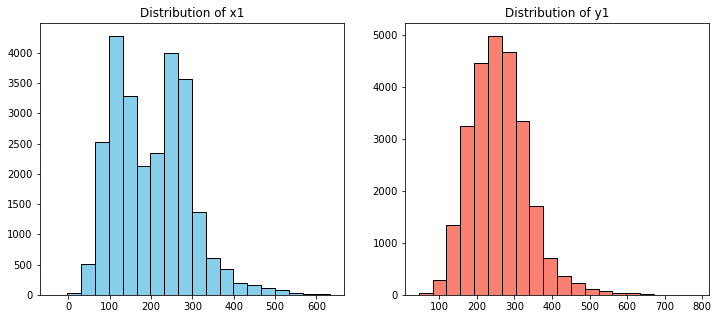

In [3]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['x1'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of x1")

plt.subplot(1, 2, 2)
plt.hist(df['y1'], bins=20, color='salmon', edgecolor='black')
plt.title("Distribution of y1")

plt.show()

# Data Visualization

In [4]:
def plot_hand_landmarks_xy(row, ax=None, title="Raw Hand Landmarks (x,y)"):
    """
    Plot hand landmarks (x,y) from a row that starts with x1,y1,z1, x2,y2,z2, ... x21,y21,z21.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    coords = row.values.reshape(21, 3)[:, :2]  
    xs = coords[:, 0]
    ys = coords[:, 1]
    ax.scatter(xs, ys, color='blue')
    
    # Draw lines from the "wrist" (landmark #1 in your CSV) to finger tips.
    wrist = (xs[0], ys[0])  # x1, y1 is the wrist
    for tip_index in [3, 7, 11, 15, 19]:  
        ax.plot([wrist[0], xs[tip_index]], [wrist[1], ys[tip_index]], 
                color='red', linestyle='--')
    ax.set_title(title)
    ax.invert_yaxis()  
    return ax

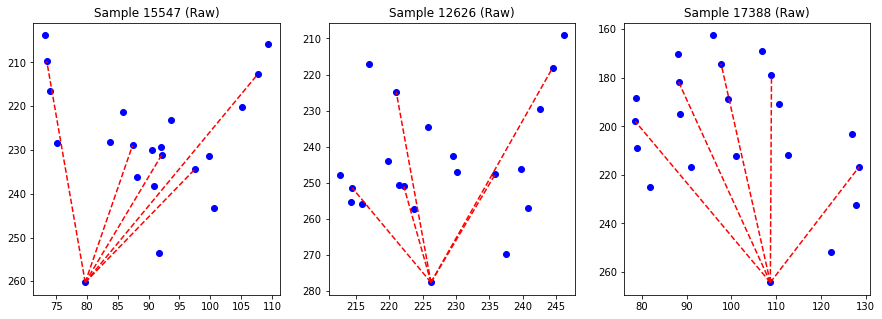

In [5]:
sample_rows = df.sample(3, random_state=42)
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, (idx, row) in enumerate(sample_rows.iterrows()):
    plot_hand_landmarks_xy(row[:-1], ax=axes[i], title=f"Sample {idx} (Raw)")
plt.show()

# Data Preprocessing

In [8]:
def process_hand_landmarks_xy(row):
    """
    Process a sample of hand landmark data by:
    - Dropping the z coordinate (keeping only x and y and thus contribute 42 features)
    - Recenter by subtracting the 1st landmark (assumed wrist: x1, y1)
    - Normalizing by dividing by the Euclidean distance from the wrist to the mid-finger tip (12th lm)
    Input: pandas Series with 63 values (x1,y1,z1,...,x21,y21,z21)
    Output: numpy array of length 42
    """
    coords = row.values.reshape(21, 3)[:, :2].copy()  
    # Use the 1st landmark as wrist (x1, y1)
    wrist = coords[0, :]
    coords = coords - wrist  # Recenter
    # Use the 12th landmark as mid-finger tip for normalization
    mid_tip = coords[11, :]
    scale = np.linalg.norm(mid_tip)
    if scale == 0:
        scale = 1.0
    coords = coords / scale
    return coords.flatten()

In [9]:
# Apply processing to every sample
X_raw = df.drop("label", axis=1)
X_processed = X_raw.apply(process_hand_landmarks_xy, axis=1, result_type='expand')
X_processed = pd.DataFrame(X_processed)
y = df["label"]
print("Processed feature shape:", X_processed.shape)

Processed feature shape: (25675, 42)


In [10]:
# Drop missing
X_processed.dropna(inplace=True)
y = y[X_processed.index]

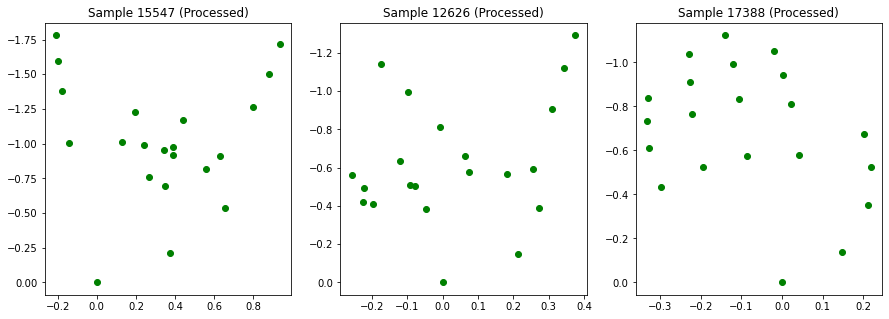

In [11]:
# Visualize a few processed samples
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, (idx, row) in enumerate(X_processed.sample(3, random_state=42).iterrows()):
    coords = row.values.reshape(21, 2)
    axes[i].scatter(coords[:, 0], coords[:, 1], color='green')
    axes[i].set_title(f"Sample {idx} (Processed)")
    axes[i].invert_yaxis()
plt.show()

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_numeric = le.fit_transform(y)
print("Unique classes (numeric):", np.unique(y_numeric))
print("Original class names:", le.classes_)

Unique classes (numeric): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Original class names: ['call' 'dislike' 'fist' 'four' 'like' 'mute' 'ok' 'one' 'palm' 'peace'
 'peace_inverted' 'rock' 'stop' 'stop_inverted' 'three' 'three2' 'two_up'
 'two_up_inverted']


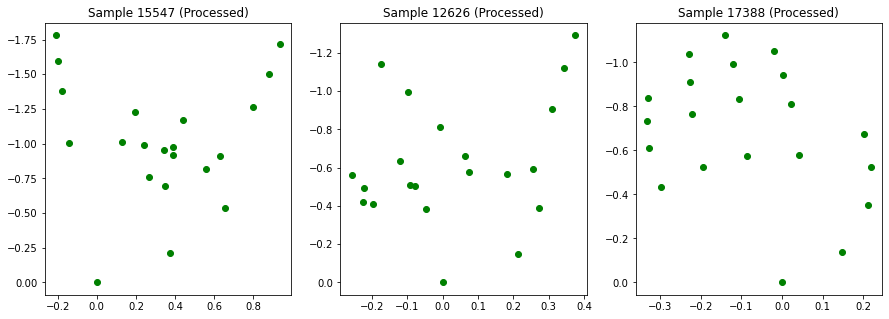

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, (idx, row) in enumerate(X_processed.sample(3, random_state=42).iterrows()):
    coords = row.values.reshape(21, 2)
    axes[i].scatter(coords[:, 0], coords[:, 1], color='green')
    axes[i].set_title(f"Sample {idx} (Processed)")
    axes[i].invert_yaxis()
plt.show()

# Data Split : 60, 20, 20 (Train, test, validation)

In [14]:
from sklearn.model_selection import train_test_split

# Train+validation (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_processed, y_numeric, test_size=0.2, random_state=42
)
# Then split train+validation into training (60%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (15405, 42)
Validation set shape: (5135, 42)
Test set shape: (5135, 42)


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import joblib

# Configurations

models = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 75, 100],
            "max_depth": [None, 10, 20]
        }
    },

    "SVM": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42),
        "params": {
            "C": [0.1, 1, 10]
        }
    },

    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10]
        }
    },
    "AdaBoost": {
        # Weak Learners
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.5, 1.0, 1.5]
        }
    },
    "XGBoost": {
        # Much better generalization
        "model": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.05, 0.1, 0.2]
        }
    },
}

In [18]:
results = {}
best_model = None
best_accuracy = 0
best_f1 = 0

# For each model, build a pipeline with StandardScaler and the classifier.
for name, config in models.items():
    print(f"\nTraining {name}...")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', config["model"])
    ])
    param_grid = {f"clf__{key}": value for key, value in config["params"].items()}
    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=1)
    grid.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_val_pred = grid.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    
    # Evaluate on test set
    y_test_pred = grid.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    prec = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    decoded_y_test_pred = le.inverse_transform(y_test_pred)
    decoded_y_test = le.inverse_transform(y_test)
    
    results[name] = {
        "best_params": grid.best_params_,
        "cv_score": grid.best_score_,
        "validation_accuracy": val_acc,
        "test_accuracy": test_acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "classification_report": classification_report(decoded_y_test, decoded_y_test_pred, target_names=le.classes_),
        "confusion_matrix": confusion_matrix(decoded_y_test, decoded_y_test_pred)
    }
    
    print(f"Best params: {grid.best_params_}")
    print(f"Mean CV Score (training set): {grid.best_score_:.10f}")
    print(f"Validation Accuracy: {val_acc:.10f}")
    print(f"Test Accuracy: {test_acc:.10f}")
    print(f"Weighted Precision: {prec:.10f}")
    print(f"Weighted Recall: {rec:.10f}")
    print(f"Weighted F1-Score: {f1:.10f}")
    print("Decoded Classification Report:\n", results[name]["classification_report"])
    print("Confusion Matrix:\n", results[name]["confusion_matrix"])
    
    if f1 > best_f1:
        best_f1 = f1
        best_model = grid.best_estimator_

# Save the best model based on weighted F1 score (Imbalanced data)
joblib.dump(best_model, "best_hand_gesture_model_dropZ_full.pkl")
print(f"\nBest model saved with weighted F1 score: {best_f1:.4f}")


Training Random Forest...
Best params: {'clf__max_depth': 20, 'clf__n_estimators': 100}
Mean CV Score (training set): 0.9737747485
Validation Accuracy: 0.9756572541
Test Accuracy: 0.9707887050
Weighted Precision: 0.9708859328
Weighted Recall: 0.9707887050
Weighted F1-Score: 0.9707841768
Decoded Classification Report:
                  precision    recall  f1-score   support

           call       0.99      0.99      0.99       287
        dislike       1.00      1.00      1.00       260
           fist       0.99      1.00      0.99       209
           four       0.97      0.96      0.96       325
           like       0.99      0.99      0.99       304
           mute       0.95      0.97      0.96       195
             ok       0.98      0.99      0.99       340
            one       0.96      0.96      0.96       248
           palm       0.98      0.99      0.98       317
          peace       0.95      0.94      0.94       276
 peace_inverted       0.97      0.94      0.95     

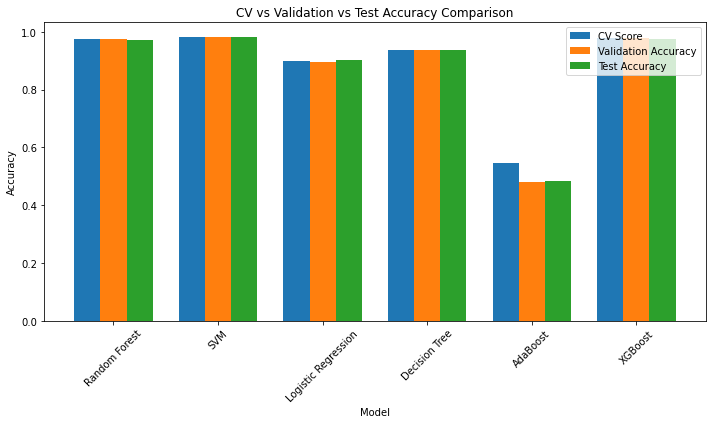

In [19]:
model_names = list(results.keys())
cv_scores = [results[m]["cv_score"] for m in model_names]
val_scores = [results[m]["validation_accuracy"] for m in model_names]
test_scores = [results[m]["test_accuracy"] for m in model_names]

plt.figure(figsize=(10, 6))
index = np.arange(len(model_names))
bar_width = 0.25

plt.bar(index, cv_scores, bar_width, label='CV Score')
plt.bar(index + bar_width, val_scores, bar_width, label='Validation Accuracy')
plt.bar(index + 2*bar_width, test_scores, bar_width, label='Test Accuracy')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('CV vs Validation vs Test Accuracy Comparison')
plt.xticks(index + bar_width, model_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
ranking_data = []
for model_name, metrics in results.items():
    ranking_data.append({
        "Model": model_name,
        "Accuracy": metrics["test_accuracy"],
        "Weighted F1": metrics["f1_score"],
        "Precision": metrics["precision"],
        "Recall": metrics["recall"]
    })

df_ranking = pd.DataFrame(ranking_data)

# Sort descendingly by Weighted F1 Score
df_ranking.sort_values(by="Weighted F1", ascending=False, inplace=True)

df_ranking.reset_index(drop=True, inplace=True)
df_ranking.index += 1 
df_ranking.rename_axis("Rank", inplace=True)

print(df_ranking)

                    Model  Accuracy  Weighted F1  Precision    Recall
Rank                                                                 
1                     SVM  0.982863     0.982869   0.982995  0.982863
2                 XGBoost  0.976826     0.976817   0.976900  0.976826
3           Random Forest  0.970789     0.970784   0.970886  0.970789
4           Decision Tree  0.937293     0.937318   0.937641  0.937293
5     Logistic Regression  0.901071     0.901120   0.901836  0.901071
6                AdaBoost  0.483934     0.425162   0.527633  0.483934


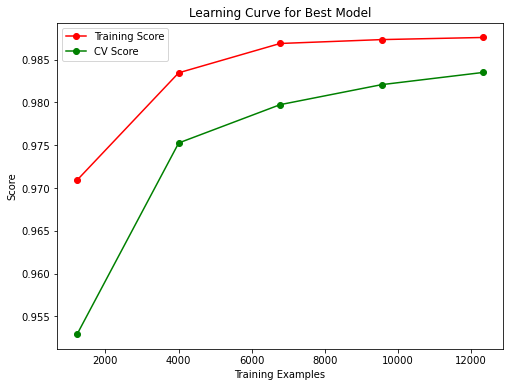

In [21]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=1):
    train_sizes, train_scores, cv_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training Score")
    plt.plot(train_sizes, cv_scores_mean, 'o-', color='g', label="CV Score")
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(best_model, "Learning Curve for Best Model", X_train, y_train, cv=5, n_jobs=1)

In [23]:
print("\n Summary of Model Performance ")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"Mean CV Score: {metrics['cv_score']:.4f}")
    print(f"Validation Accuracy: {metrics['validation_accuracy']:.4f}")
    print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
    print(f"Weighted Precision: {metrics['precision']:.4f}")
    print(f"Weighted Recall: {metrics['recall']:.4f}")
    print(f"Weighted F1-Score: {metrics['f1_score']:.4f}")

print("\n Conclusion: ")
print(" - Data was split into training (60%), validation (20%), and test (20%) sets.")
print(" - GridSearchCV with 5-fold CV on the training set provided internal validation.")
print(" - Comparing validation and test performance helps ensure no overfitting.")
print(" - The bar chart comparing CV, validation, and test accuracy confirms model generalization.")
print(" - For multi-class classification with class imbalance, the weighted F1-score is recommended.")


 Summary of Model Performance 

Random Forest:
Mean CV Score: 0.9738
Validation Accuracy: 0.9757
Test Accuracy: 0.9708
Weighted Precision: 0.9709
Weighted Recall: 0.9708
Weighted F1-Score: 0.9708

SVM:
Mean CV Score: 0.9835
Validation Accuracy: 0.9827
Test Accuracy: 0.9829
Weighted Precision: 0.9830
Weighted Recall: 0.9829
Weighted F1-Score: 0.9829

Logistic Regression:
Mean CV Score: 0.8991
Validation Accuracy: 0.8972
Test Accuracy: 0.9011
Weighted Precision: 0.9018
Weighted Recall: 0.9011
Weighted F1-Score: 0.9011

Decision Tree:
Mean CV Score: 0.9363
Validation Accuracy: 0.9373
Test Accuracy: 0.9373
Weighted Precision: 0.9376
Weighted Recall: 0.9373
Weighted F1-Score: 0.9373

AdaBoost:
Mean CV Score: 0.5480
Validation Accuracy: 0.4816
Test Accuracy: 0.4839
Weighted Precision: 0.5276
Weighted Recall: 0.4839
Weighted F1-Score: 0.4252

XGBoost:
Mean CV Score: 0.9783
Validation Accuracy: 0.9799
Test Accuracy: 0.9768
Weighted Precision: 0.9769
Weighted Recall: 0.9768
Weighted F1-Score: 

In [24]:
import cv2
import mediapipe as mp
from statistics import mode
from collections import deque

# Load the best saved model
model = joblib.load("best_hand_gesture_model_dropZ_full.pkl")

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.7, min_tracking_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

cap = cv2.VideoCapture(0)
pred_window = deque(maxlen=10)  # Sliding window (2 ptrs deque ds) for stabilization

while 1:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.flip(frame, 1)
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)
    gesture_pred = "No Gesture"
    
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            # Extract (x,y) coordinates from the 21 landmarks
            coords = []
            for i in range(21):
                coords.extend([hand_landmarks.landmark[i].x, hand_landmarks.landmark[i].y])
            sample = np.array(coords).reshape(21, 2)
            # Preprocess: recenter using the 1st landmark and normalize using the 12th landmark
            wrist = sample[0, :]
            sample = sample - wrist
            mid_tip = sample[11, :]
            scale = np.linalg.norm(mid_tip)
            if scale == 0:
                scale = 1.0
            sample = sample / scale
            sample_flat = sample.flatten().reshape(1, -1)
            
            pred = model.predict(sample_flat)[0]
            pred_window.append(pred)
            # Decoding numeric vals
            gesture_numeric = mode(pred_window)
            gesture_pred = le.inverse_transform([gesture_numeric])[0]
    
    cv2.putText(frame, f"Gesture: {gesture_pred}", (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.imshow("Real-Time Gesture Recognition (Drop z)", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 